In [ ]:
!pip install facenet-pytorch

### Model 1: FaceNet + SVM
Model ini menggabungkan arsitektur FaceNet dengan Support Vector Machine (SVM) untuk tugas pengenalan wajah. Berikut adalah langkah-langkahnya:

**Ekstraksi Wajah (MTCNN)**: Menggunakan Multi-task Cascaded Convolutional Networks (MTCNN) untuk mendeteksi wajah dalam gambar dan melakukan cropping (pemotongan) agar hanya wajah yang tersisa. Ini memastikan input untuk model selanjutnya terstandarisasi.
Ekstraksi Fitur Wajah (InceptionResnetV1):

 **Bagian utama dari FaceNet**, yaitu model **InceptionResnetV1** yang telah dilatih sebelumnya (pretrained on 'vggface2'). Model ini berfungsi untuk mengubah gambar wajah yang sudah dipotong menjadi representasi numerik (disebut embedding atau vektor fitur) berdimensi tinggi. Embedding ini menangkap karakteristik unik dari setiap wajah.

**Klasifikasi (SVM)**: Embedding wajah yang dihasilkan kemudian digunakan untuk melatih Support Vector Machine (SVM). SVM adalah algoritma machine learning yang efektif untuk tugas klasifikasi. Ia akan belajar membedakan kelas (misalnya, identitas orang) berdasarkan embedding wajah yang berbeda. Model ini dilatih dan divalidasi, lalu disimpan sebagai file .pth.

🔗 Menghubungkan ke Drive...
📂 Mengekstrak dataset (/content/drive/MyDrive/Dataset_Augmented_40.zip)...
✅ Dataset siap di: /content/dataset_svm_final
⚙️ Device: cuda
🚀 Memproses 3080 gambar...


100%|██████████| 3080/3080 [25:28<00:00,  2.01it/s]


✅ Selesai! 2822 wajah valid berhasil diekstrak.

🎓 Melatih SVM...
------------------------------
🏆 AKURASI VALIDASI: 94.34%
------------------------------


<Figure size 800x600 with 0 Axes>

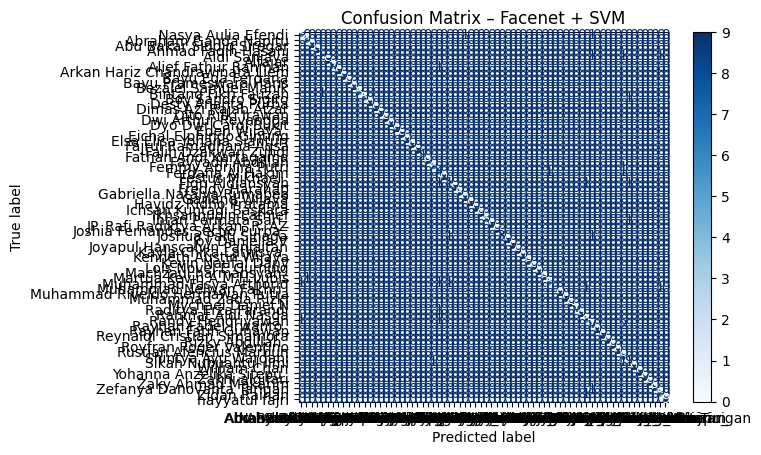

💾 Menyimpan Model Final (.pth)...
✅ SUKSES! File model tersimpan di: /content/drive/MyDrive/face_svm_augmented.pth
👉 Download file ini dan kirim ke Fadil!


In [ ]:
# ==========================================
# MODEL FINAL (Facenet + SVM)
# ==========================================
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil
from tqdm import tqdm
from google.colab import drive

# 1. SETUP & EKSTRAK DATA
print("🔗 Menghubungkan ke Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Lokasi Dataset Augmentasi
zip_path = '/content/drive/MyDrive/Dataset_Augmented_40.zip'
extract_path = '/content/dataset_svm_final'

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

print(f"📂 Mengekstrak dataset ({zip_path})...")
if not os.path.exists(zip_path):
    raise FileNotFoundError("❌ File Dataset_Augmented_40.zip tidak ditemukan!")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Cari folder root otomatis
dataset_root = extract_path
for root, dirs, files in os.walk(extract_path):
    if 'Train' in dirs:
        dataset_root = os.path.join(root, 'Train')
        break
    if any(os.path.isdir(os.path.join(root, d)) for d in dirs):
        dataset_root = root
        break

print(f"✅ Dataset siap di: {dataset_root}")

# 2. SETUP ENGINE AI
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Device: {device}")

# MTCNN (Deteksi Wajah)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# InceptionResnetV1 (Ekstraktor Fitur)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# 3. EKSTRAKSI FITUR (EMBEDDING)
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(dataset_root)
dataset.idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=2)

print(f"🚀 Memproses {len(dataset)} gambar...")

embeddings = []
labels = []

resnet.eval()
with torch.no_grad():
    for img, idx in tqdm(loader):
        # Deteksi & Crop
        x_aligned = mtcnn(img)

        if x_aligned is not None:
            # Hitung Embedding
            x_input = x_aligned.to(device).unsqueeze(0)
            emb = resnet(x_input).cpu().numpy()[0]

            embeddings.append(emb)
            labels.append(dataset.idx_to_class[idx])

embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"✅ Selesai! {len(embeddings)} wajah valid berhasil diekstrak.")

# 4. TRAINING & EVALUASI
print("\n🎓 Melatih SVM...")
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

# Latih SVM
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Cek Akurasi
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("-" * 30)
print(f"🏆 AKURASI VALIDASI: {acc*100:.2f}%")
print("-" * 30)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – Facenet + SVM")
plt.show()

# 5. RETRAIN FINAL & SIMPAN (.pth)
print("💾 Menyimpan Model Final (.pth)...")
final_clf = SVC(kernel='linear', probability=True)
final_clf.fit(embeddings, labels) # Latih pakai semua data

# Bungkus dalam Dictionary biar rapi
final_state = {
    'classifier': final_clf,       # Otak SVM
    'classes': final_clf.classes_  # Daftar Nama
}

save_path = '/content/drive/MyDrive/face_svm_augmented.pth'
torch.save(final_state, save_path)

print(f"✅ SUKSES! File model tersimpan di: {save_path}")
print("👉 Download file ini dan kirim ke Fadil!")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(1000,1000))  # diperbesar lagi

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')

# --- PERBAIKAN LABEL ---
plt.xticks(fontsize=8)  # rotasi 75 derajat
plt.yticks(fontsize=8)

# Title & Axis label
disp.ax_.set_xlabel("Predicted", fontsize=18)
disp.ax_.set_ylabel("True", fontsize=18)

plt.title("Confusion Matrix – Facenet + SVM (Validation Split)", fontsize=22)
plt.tight_layout()

plt.show()

### Model ViT (Vision Transformer) + SVM
Model ini memiliki alur serupa namun menggunakan teknologi yang berbeda untuk ekstraksi fitur:

**Deteksi dan Penyelarasan Wajah (MTCNN)**: Sama seperti sebelumnya, MTCNN digunakan untuk mendeteksi dan memotong wajah. Perbedaannya, ukuran gambar wajah disesuaikan menjadi 224x224 piksel, yang merupakan ukuran standar untuk model Vision Transformer.

**Ekstraksi Fitur (ViT Base)**: Bagian intinya adalah menggunakan model vit_base_patch16_224 (Vision Transformer Base) yang juga sudah dilatih sebelumnya (pretrained). ViT memproses gambar dengan cara yang berbeda dari CNN tradisional, memecah gambar menjadi potongan-potongan (patches) dan menganalisis hubungan antar potongan tersebut untuk menghasilkan vektor fitur (embedding) yang sangat kaya informasi.

**Klasifikasi (SVM)**: Vektor fitur yang dihasilkan oleh ViT kemudian menjadi input untuk SVM. SVM dilatih untuk mengklasifikasikan identitas wajah berdasarkan fitur-fitur canggih yang dihasilkan oleh ViT. Model SVM yang sudah dilatih ini juga disimpan.
Singkatnya: Kedua model ini sama-sama menggunakan MTCNN untuk mendeteksi wajah dan SVM untuk klasifikasi akhir. Perbedaan utamanya terletak pada teknologi yang digunakan untuk mengekstrak fitur wajah: satu menggunakan arsitektur CNN (FaceNet/InceptionResnetV1), sementara yang lain menggunakan arsitektur Transformer (ViT).

In [ ]:
import torch
import timm
from facenet_pytorch import MTCNN
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil
from tqdm import tqdm
from google.colab import drive
import pickle

# ==========================================
# 1. SETUP & DATASET
# ==========================================
print("🔗 Menghubungkan ke Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Gunakan Dataset Augmentasi (40 gambar)
zip_path = '/content/drive/MyDrive/Dataset_Augmented_40.zip'
extract_path = '/content/dataset_vit_svm'

if os.path.exists(extract_path): shutil.rmtree(extract_path)

print(f"📂 Mengekstrak dataset...")
if not os.path.exists(zip_path):
    raise FileNotFoundError("❌ File Dataset_Augmented_40.zip tidak ditemukan!")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Cari root folder otomatis
dataset_root = extract_path
for root, dirs, files in os.walk(extract_path):
    if 'Train' in dirs:
        dataset_root = os.path.join(root, 'Train')
        break
    if any(os.path.isdir(os.path.join(root, d)) for d in dirs):
        dataset_root = root
        break

print(f"✅ Dataset siap di: {dataset_root}")

# ==========================================
# 2. SETUP ENGINE (MTCNN + ViT PRETRAINED)
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Device: {device}")

# Detektor Wajah
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20, # ViT butuh 224x224
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Feature Extractor: ViT Base (Pre-trained ImageNet-21k)
# num_classes=0 artinya kita buang layer klasifikasi (ambil embedding aja)
print("📥 Memuat ViT Pre-trained (Frozen)...")
vit_model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True, num_classes=0)
vit_model = vit_model.to(device)
vit_model.eval() # Mode Evaluasi (Frozen)

# ==========================================
# 3. EKSTRAKSI FITUR
# ==========================================
def collate_fn(x): return x[0]

try:
    dataset = datasets.ImageFolder(dataset_root)
    dataset.idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
    loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=2)

    embeddings = []
    labels = []

    print(f"🚀 Mengekstrak fitur dari {len(dataset)} gambar...")

    with torch.no_grad():
        for img, idx in tqdm(loader):
            # 1. Deteksi Wajah
            x_aligned = mtcnn(img)

            if x_aligned is not None:
                # Normalisasi manual ala ViT (ImageNet stats)
                # MTCNN output (0..1), ViT butuh normalisasi spesifik
                # x_aligned shape: [3, 224, 224]

                # Standarisasi ImageNet (Mean=[0.5, 0.5, 0.5], Std=[0.5, 0.5, 0.5]) untuk aman
                x_input = (x_aligned - 0.5) / 0.5
                x_input = x_input.unsqueeze(0).to(device)

                # 2. Ekstrak Embedding
                emb = vit_model(x_input).cpu().numpy()[0]

                embeddings.append(emb)
                labels.append(dataset.idx_to_class[idx])

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    print(f"✅ Selesai! Dimensi Fitur: {embeddings.shape}")

    # ==========================================
    # 4. TRAINING SVM & EVALUASI
    # ==========================================
    print("\n🎓 Melatih SVM...")
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)

    acc = accuracy_score(y_test, clf.predict(X_test))
    print("-" * 30)
    print(f"🏆 AKURASI VALIDASI (ViT+SVM): {acc*100:.2f}%")
    print("-" * 30)

    # ==========================================
    # CONFUSION MATRIX
    # ==========================================

    cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix – ViT + SVM")
    plt.show()

    # ==========================================
    # 5. SIMPAN MODEL (.pth)
    # ==========================================
    print("💾 Menyimpan Model Final...")
    # Latih ulang dengan SEMUA data
    final_clf = SVC(kernel='linear', probability=True)
    final_clf.fit(embeddings, labels)

    state = {
        'classifier': final_clf,
        'classes': final_clf.classes_,
        'model_name': 'vit_base_patch16_224' # Metadata
    }

    save_path = '/content/drive/MyDrive/face_vit_svm_augmented.pth'
    torch.save(state, save_path)
    print(f"✅ Model tersimpan di: {save_path}")
    print("👉 Download file ini untuk dipakai di Streamlit!")

except Exception as e:
    print(f"❌ Terjadi Kesalahan: {e}")

🔗 Menghubungkan ke Drive...
📂 Mengekstrak dataset...


FileNotFoundError: ❌ File Dataset_Augmented_40.zip tidak ditemukan!